# RocketML Tutorial on distributed object detection on videos

## Import Libraries

In [1]:
from rocketml.io import VideoSet, MongoWriter, Video
from rocketml.feature_extraction import ObjectDetection
from rocketml.pipeline import Pipeline
import sys

import uuid

import pymongo
from pprint import pprint
import subprocess
from time import time

from IPython.core.display import display, HTML

## Create a videoset using video paths

In [8]:
start = time()
filename = "/home/ubuntu/rml-notebooks/home_video_list_4.txt"
# Image Set
vm = VideoSet(filename,resize_width=64,resize_height=64)

# Object Detection
od = ObjectDetection(model_type="ssd_inception_v2_coco_2017_11_17",model_framework="tensorflow")
#od = ObjectDetection(model_type="yolo_v2",model_framework="darknet")

# Get uri
hname = subprocess.check_output(["hostname"])
mongo_uri = "mongodb://"+hname.strip()+":27017"

collection_name = "test_run_" + str(uuid.uuid4())
# MongoWriter
mw = MongoWriter(uri=mongo_uri,db="rml_collection_video_tf_demo",collection=collection_name)

# Pipeline
pipeline = Pipeline([od,mw])
pipeline.fit(vm,cores="all")

#Get Mongo client
client = pymongo.MongoClient(mongo_uri)

# set the database
db=pymongo.database.Database(client,mw.params['db'])

collection = pymongo.collection.Collection(db,mw.params["collection"])
total_frames = collection.count()

# Get Frame/Second
od_fps = total_frames*1.0/(time()-start)
string = "<h1>Object detection (images/second) = " + ("%.2f"%od_fps) + "</h1>"
display(HTML(string))

video
------------------
Cluster Resources
------------------
Nodes        = 4
Sockets/node = 1
Cores/socket = 8
--------------------------
Total Cores    = 32
Total Memory(GB)   = 121.68
--------------------------


## Inspect objects on a single video

In [9]:
vid = Video(filename="/home/ubuntu/rocketml-dev/data/home-videos/santi_lr_1.MOV")
vid.draw_objects(mw,"out_tf_santi_lr_1.mp4")

[u'test_run_8e162602-2cda-4fcb-9155-0ade261f43ea', u'system.indexes', u'test_run_3ffb49b3-a399-4504-997a-51b986971db1', u'test_run_b6a9cfd9-e108-47c9-8f87-3f041632798d', u'test_run_72686dc8-1d2b-437d-a475-3229dd04a16b', u'test_run_ffe6b20e-9374-47ba-9016-9af0611e745b', u'test_run_d7024718-bd1d-4ad0-b07d-36f9349f0660', u'test_run_fb9da6d9-4da2-401e-9fe4-53f364c39f6e', u'test_run_e76635ff-cbf7-4776-88e6-0e5b1506f68c', u'test_run_bc9e63a4-ae02-4318-ac9a-7088821a8f27', u'test_run_8719af04-5203-4ee4-bdb5-b53bac936fa7', u'test_run_a79d2d0a-3989-4fc2-80f5-cfea268ceec2']


In [10]:
import json
from pprint import pprint

### Bring your own models using configuration files

In [11]:
with open("/etc/rocketml.d/object_detection/object_detection_models_config.json","r") as fp:
    data = json.load(fp)

In [12]:
print json.dumps(data,indent=1)

{
 "ssd_inception_v2_coco_2017_11_17": {
  "tensorflow": {
   "scale_factor": 0.00784313725490196, 
   "model_binary": "/etc/rocketml.d/object_detection/ssd_inception_v2_coco_2017_11_17_frozen_inference_graph.pb", 
   "model_config": "/etc/rocketml.d/object_detection/ssd_inception_v2_coco_2017_11_17.pbtxt", 
   "size_x": 300.0, 
   "size_y": 300.0, 
   "channel_scale_2": 127.5, 
   "channel_scale_3": 127.5, 
   "class_names": "/etc/rocketml.d/object_detection/ssd_inception_v2_coco_2017_11_17_class_names.json", 
   "channel_scale_1": 127.5
  }
 }, 
 "yolo_v2": {
  "darknet": {
   "scale_factor": 0.00392156862745098, 
   "model_binary": "/etc/rocketml.d/object_detection/yolo.weights", 
   "model_config": "/etc/rocketml.d/object_detection/yolo.cfg", 
   "size_x": 416.0, 
   "size_y": 416.0, 
   "channel_scale_2": 0.0, 
   "channel_scale_3": 0.0, 
   "class_names": "/etc/rocketml.d/object_detection/yolo_class_names.json", 
   "channel_scale_1": 0.0
  }
 }
}


### Identify Activity Box

In [14]:
filename = "/home/ubuntu/rocketml-dev/data/videos/zoom_0.mp4"
hname = subprocess.check_output(["hostname"])


vd = VideoSet(filelist=[filename])
od = ObjectDetection()
collection_name = "test1_video_bbox_" + str(uuid.uuid4())[:4]

mw = MongoWriter(uri=mongo_uri,db="rml_video_bbox",collection=collection_name)

pp = Pipeline([od,mw])
pp.fit(vd)

video
------------------
Cluster Resources
------------------
Nodes        = 1
Sockets/node = 1
Cores/socket = 1
--------------------------
Total Cores    = 1
Total Memory(GB)   = 30.42
--------------------------


In [15]:
import cv2
vv = Video(filename)
xll,yll,xur,yur = vv.get_activity_window(mw)
print("%d,%d,%d,%d"%(xll,yll,xur,yur))

cap = cv2.VideoCapture(filename)
cap.set(cv2.CAP_PROP_POS_FRAMES,100)
ret,frame = cap.read()
cv2.rectangle(frame,(xll,yll),(xur,yur),(125, 255, 51), thickness=2)
cap.release()

[u'test1', u'system.indexes', u'test1_video_bbox_9578', u'test1_video_bbox_fd6f', u'test1_video_bbox_08f2', u'test1_video_bbox_6b72', u'test1_video_bbox_0725', u'test1_video_bbox_012a', u'test1_video_bbox_cf05', u'test1_video_bbox_66e7']
888,137,1199,498


In [16]:
import matplotlib.pyplot as plt

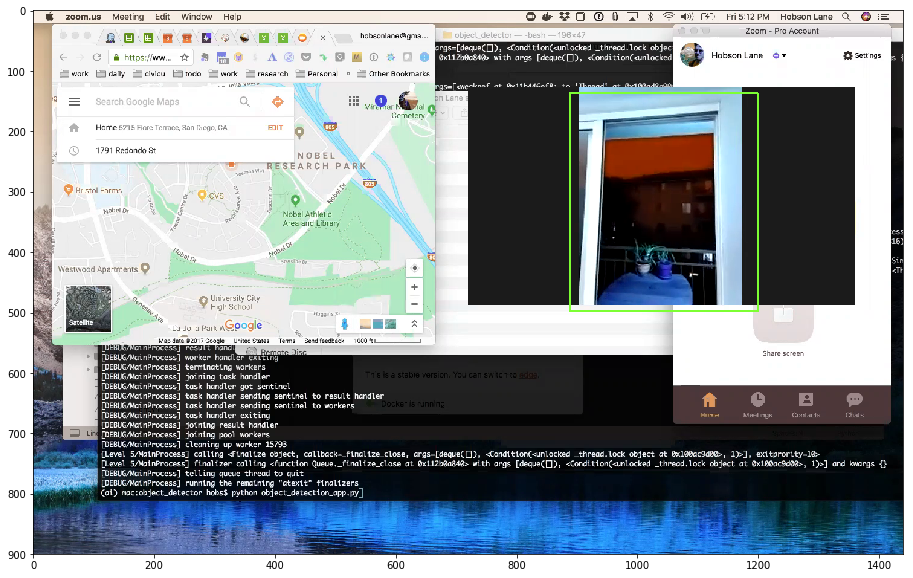

In [17]:
plt.rcParams['figure.figsize'] = [20,10]
plt.imshow(frame,aspect="equal",interpolation="nearest")

In [64]:
cv2.imwrite('out_bbox.png',frame)

True